In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
memory = True
gpus = tf.config.list_physical_devices('GPU')
if gpus and memory:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1


2022-10-14 13:35:03.716527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 13:35:03.721278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 13:35:03.721508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [12]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="EfficientNetB2/EfficientNetB2 history"+current_time,dpi=300)

In [13]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [14]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
preview_dataset(ds_test)

tf.Tensor(
[[[[0.04781801 0.04088994 0.02489108]
   [0.04781801 0.04088994 0.02489108]
   [0.04935362 0.04103278 0.02299836]
   ...
   [0.04710378 0.03485465 0.02306978]
   [0.04538961 0.03110492 0.01989144]
   [0.0471752  0.03414042 0.02014142]]

  [[0.04781801 0.04088994 0.02489108]
   [0.04781801 0.04088994 0.02489108]
   [0.04935362 0.04103278 0.02299836]
   ...
   [0.04710378 0.03485465 0.02306978]
   [0.04538961 0.03110492 0.01989144]
   [0.0471752  0.03414042 0.02014142]]

  [[0.04856796 0.04042568 0.02321263]
   [0.04856796 0.04042568 0.02321263]
   [0.04913935 0.04110421 0.02303407]
   ...
   [0.04842511 0.03585458 0.02528391]
   [0.0465681  0.03264052 0.02260553]
   [0.04610385 0.03403328 0.02007   ]]

  ...

  [[0.04863938 0.03935433 0.02431969]
   [0.04863938 0.03935433 0.02431969]
   [0.04835369 0.03874723 0.02460539]
   ...
   [0.04917506 0.03939004 0.02856939]
   [0.04938933 0.03867581 0.02814085]
   [0.05149632 0.03949718 0.03078352]]

  [[0.04796086 0.03889008 0.024926

tf.Tensor(
[[[[0.04721091 0.03881866 0.03553317]
   [0.04721091 0.03881866 0.03553317]
   [0.04349689 0.03510464 0.02996214]
   ...
   [0.04110421 0.03442611 0.0267838 ]
   [0.0383544  0.03153346 0.02249839]
   [0.03928291 0.03235483 0.02414113]]

  [[0.04721091 0.03881866 0.03553317]
   [0.04721091 0.03881866 0.03553317]
   [0.04349689 0.03510464 0.02996214]
   ...
   [0.04110421 0.03442611 0.0267838 ]
   [0.0383544  0.03153346 0.02249839]
   [0.03928291 0.03235483 0.02414113]]

  [[0.04742518 0.04046139 0.04024712]
   [0.04742518 0.04046139 0.04024712]
   [0.04756803 0.03978287 0.03674737]
   ...
   [0.03928291 0.03246197 0.02389115]
   [0.041997   0.03385472 0.02814085]
   [0.04274695 0.03449754 0.03006928]]

  ...

  [[0.03631883 0.02817656 0.01846297]
   [0.03631883 0.02817656 0.01846297]
   [0.0398543  0.03406899 0.02821227]
   ...
   [0.03567602 0.02885508 0.01907007]
   [0.03567602 0.02803371 0.01810585]
   [0.03567602 0.02674809 0.01896293]]

  [[0.03635455 0.02821227 0.020355

2022-10-13 14:08:11.132601: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.07)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [ ]:
def augment_data(image,label):
  #image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  #image=augment_hue(image)
  image=augment_saturation(image)
  #image=augment_brightness(image)
  #image=augment_contrast(image)


  return image,label

In [ ]:
ds_train_augmented = ds_train.map(augment_data)

In [15]:
resnet = tf.keras.applications.EfficientNetB2(include_top = False,
                                          input_shape = (64,64,3),
                                          classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

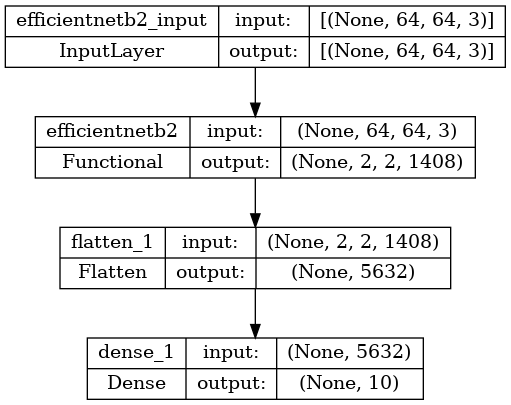

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.000005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [17]:
history = model.fit(
    ds_train_augmented,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetB2/EfficientNetB2 epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
    )
)

Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 2.3047 - sparse_categorical_accuracy: 0.2189

INFO:tensorflow:Assets written to: bestmodelEfficientNetB201-2.40/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB201-2.40/assets


169/169 [==============================] - 76s 399ms/step - loss: 2.3047 - sparse_categorical_accuracy: 0.2189 - val_loss: 2.3995 - val_sparse_categorical_accuracy: 0.1074
Epoch 2/100
169/169 [==============================] - 28s 163ms/step - loss: 1.8064 - sparse_categorical_accuracy: 0.3838 - val_loss: 3.1374 - val_sparse_categorical_accuracy: 0.1078
Epoch 3/100
169/169 [==============================] - 27s 161ms/step - loss: 1.5435 - sparse_categorical_accuracy: 0.4703 - val_loss: 1571.6630 - val_sparse_categorical_accuracy: 0.1507
Epoch 4/100
169/169 [==============================] - 27s 159ms/step - loss: 1.3702 - sparse_categorical_accuracy: 0.5371 - val_loss: 5795.4766 - val_sparse_categorical_accuracy: 0.0933
Epoch 5/100
169/169 [==============================] - 27s 160ms/step - loss: 1.2484 - sparse_categorical_accuracy: 0.5735 - val_loss: 181.6137 - val_sparse_categorical_accuracy: 0.0767
Epoch 6/100
169/169 [==============================] - 27s 160ms/step - loss: 1.1660

INFO:tensorflow:Assets written to: bestmodelEfficientNetB217-2.33/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB217-2.33/assets


169/169 [==============================] - 62s 368ms/step - loss: 0.7318 - sparse_categorical_accuracy: 0.7438 - val_loss: 2.3327 - val_sparse_categorical_accuracy: 0.2878
Epoch 18/100
169/169 [==============================] - 26s 155ms/step - loss: 0.7036 - sparse_categorical_accuracy: 0.7561 - val_loss: 2.8727 - val_sparse_categorical_accuracy: 0.1059
Epoch 19/100
169/169 [==============================] - 26s 154ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.7568 - val_loss: 2.8637 - val_sparse_categorical_accuracy: 0.0878
Epoch 20/100
169/169 [==============================] - ETA: 0s - loss: 0.6787 - sparse_categorical_accuracy: 0.7615

INFO:tensorflow:Assets written to: bestmodelEfficientNetB220-1.94/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB220-1.94/assets


169/169 [==============================] - 61s 363ms/step - loss: 0.6787 - sparse_categorical_accuracy: 0.7615 - val_loss: 1.9355 - val_sparse_categorical_accuracy: 0.3274
Epoch 21/100
169/169 [==============================] - ETA: 0s - loss: 0.6539 - sparse_categorical_accuracy: 0.7727

INFO:tensorflow:Assets written to: bestmodelEfficientNetB221-1.69/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB221-1.69/assets


169/169 [==============================] - 61s 362ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.7727 - val_loss: 1.6935 - val_sparse_categorical_accuracy: 0.4470
Epoch 22/100
169/169 [==============================] - 26s 154ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.7745 - val_loss: 2.6043 - val_sparse_categorical_accuracy: 0.2085
Epoch 23/100
169/169 [==============================] - 26s 154ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.7813 - val_loss: 3.5634 - val_sparse_categorical_accuracy: 0.1252
Epoch 24/100
169/169 [==============================] - 26s 155ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.7857 - val_loss: 2.1247 - val_sparse_categorical_accuracy: 0.3244
Epoch 25/100
169/169 [==============================] - 26s 156ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7916 - val_loss: 1.7985 - val_sparse_categorical_accuracy: 0.4730
Epoch 26/100
169/169 [==============================] - 27s 159ms/step - loss: 0.5685 - 

INFO:tensorflow:Assets written to: bestmodelEfficientNetB234-1.62/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB234-1.62/assets


169/169 [==============================] - 60s 358ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.8289 - val_loss: 1.6208 - val_sparse_categorical_accuracy: 0.5033
Epoch 35/100
169/169 [==============================] - 27s 158ms/step - loss: 0.4856 - sparse_categorical_accuracy: 0.8294 - val_loss: 2.6854 - val_sparse_categorical_accuracy: 0.2437
Epoch 36/100
169/169 [==============================] - 27s 159ms/step - loss: 0.4712 - sparse_categorical_accuracy: 0.8350 - val_loss: 3.2197 - val_sparse_categorical_accuracy: 0.2074
Epoch 37/100
169/169 [==============================] - 26s 156ms/step - loss: 0.4610 - sparse_categorical_accuracy: 0.8359 - val_loss: 4.6572 - val_sparse_categorical_accuracy: 0.2026
Epoch 38/100
169/169 [==============================] - 27s 160ms/step - loss: 0.4531 - sparse_categorical_accuracy: 0.8425 - val_loss: 4.1788 - val_sparse_categorical_accuracy: 0.1607
Epoch 39/100
169/169 [==============================] - 27s 159ms/step - loss: 0.4495 - 

INFO:tensorflow:Assets written to: bestmodelEfficientNetB288-1.29/assets


INFO:tensorflow:Assets written to: bestmodelEfficientNetB288-1.29/assets


169/169 [==============================] - 63s 375ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9318 - val_loss: 1.2926 - val_sparse_categorical_accuracy: 0.6574
Epoch 89/100
169/169 [==============================] - 27s 162ms/step - loss: 0.1909 - sparse_categorical_accuracy: 0.9355 - val_loss: 1.7517 - val_sparse_categorical_accuracy: 0.5941
Epoch 90/100
169/169 [==============================] - 27s 162ms/step - loss: 0.1984 - sparse_categorical_accuracy: 0.9325 - val_loss: 2.2895 - val_sparse_categorical_accuracy: 0.3630
Epoch 91/100
169/169 [==============================] - 28s 163ms/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9348 - val_loss: 2.7679 - val_sparse_categorical_accuracy: 0.4130
Epoch 92/100
169/169 [==============================] - 27s 161ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9368 - val_loss: 1.5270 - val_sparse_categorical_accuracy: 0.5607
Epoch 93/100
169/169 [==============================] - 27s 160ms/step - loss: 0.1875 - 


Test accuracy: 0.15740740299224854


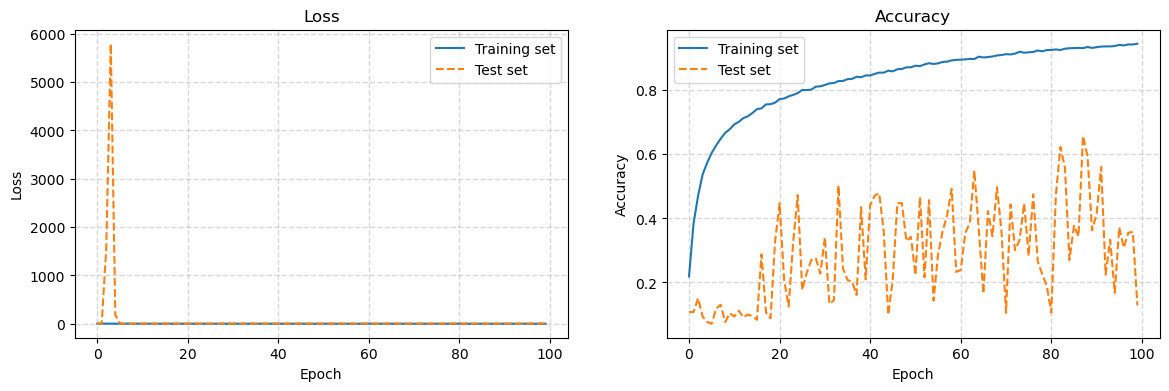

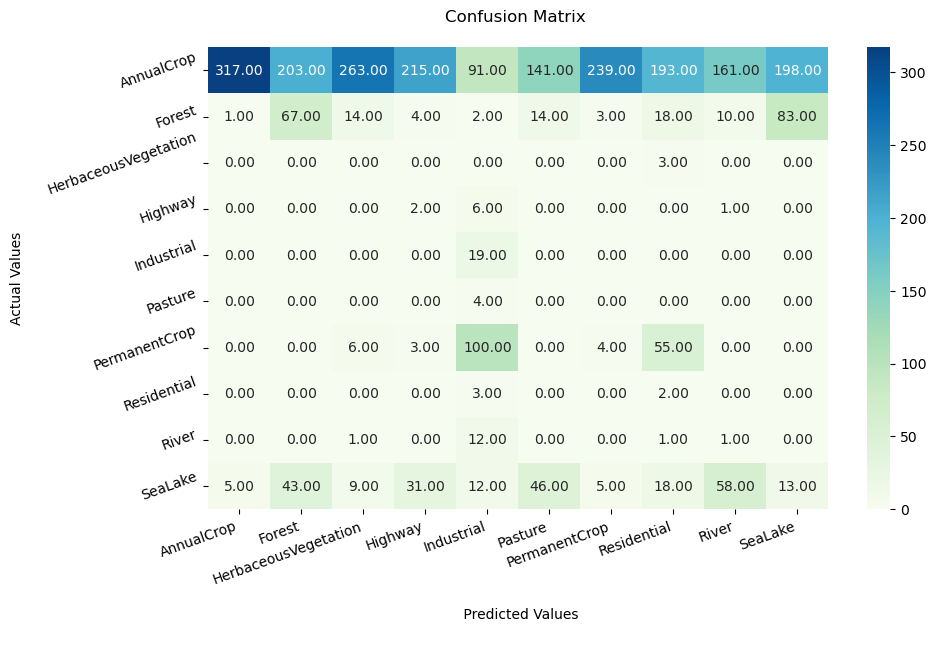

In [18]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="EfficientNetB2/EfficientNetB2 confusion matrix"+current_time,dpi=300)
render_training_history(history)
